In [1]:
import scanpy as sc
import sys
sys.path.append("/home/zflu/multiomics")
adata_RNA = sc.read_h5ad('/home/zflu/scMODAL/Data/data1/RNA.h5ad')
adata_ADT = sc.read_h5ad('/home/zflu/scMODAL/Data/data1/ADT.h5ad')

In [2]:
import anndata as ad
import numpy as np 
import pandas as pd
adata_RNA = sc.read_h5ad('/home/zflu/scMODAL/Data/data1/RNA.h5ad')
adata_ADT = sc.read_h5ad('/home/zflu/scMODAL/Data/data1/ADT.h5ad')
adata_ADT.obs['celltype'] = adata_RNA.obs['celltype']
correspondence = pd.read_csv('/home/zflu/scMODAL/Data/data1/protein_gene_conversion.csv')
correspondence['Protein name'] = correspondence['Protein name'].replace(to_replace={'TCRab': 'TCR-a/b', 'TCRgd': 'TCR-g/d'})
print(correspondence)

rna_protein_correspondence = []

for i in range(correspondence.shape[0]):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    if curr_protein_name not in adata_ADT.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in adata_RNA.var_names:
            rna_protein_correspondence.append([r, curr_protein_name])

rna_protein_correspondence = np.array(rna_protein_correspondence)
RNA_shared = adata_RNA[:, rna_protein_correspondence[:, 0]].copy()
ADT_shared = adata_ADT[:, rna_protein_correspondence[:, 1]].copy()
RNA_shared.var['feature_name'] = RNA_shared.var.index.values
ADT_shared.var['feature_name'] = ADT_shared.var.index.values
RNA_shared.var_names_make_unique()
ADT_shared.var_names_make_unique()

RNA_unshared = adata_RNA[:, sorted(set(adata_RNA.var.index) - set(rna_protein_correspondence[:, 0]))].copy()
ADT_unshared = adata_ADT[:, sorted(set(adata_ADT.var.index) - set(rna_protein_correspondence[:, 1]))].copy()

sc.pp.highly_variable_genes(RNA_unshared, flavor='seurat_v3', n_top_genes=1000)
RNA_unshared = RNA_unshared[:, RNA_unshared.var.highly_variable].copy()

RNA_unshared.var['feature_name'] = RNA_unshared.var.index.values
ADT_unshared.var['feature_name'] = ADT_unshared.var.index.values
RNA_counts = RNA_shared.X.sum(axis=1)
ADT_counts = ADT_shared.X.sum(axis=1)
target_sum = np.maximum(np.median(np.array(RNA_counts).copy()), 20)

sc.pp.normalize_total(RNA_shared, target_sum=target_sum)
sc.pp.log1p(RNA_shared)
sc.pp.scale(RNA_shared, max_value=10)

sc.pp.normalize_total(ADT_shared, target_sum=target_sum)
sc.pp.log1p(ADT_shared)
sc.pp.scale(ADT_shared, max_value=10)

sc.pp.normalize_total(RNA_unshared)
sc.pp.log1p(RNA_unshared)
sc.pp.scale(RNA_unshared, max_value=10)

sc.pp.normalize_total(ADT_unshared)
sc.pp.log1p(ADT_unshared)
sc.pp.scale(ADT_unshared, max_value=10)

adata1 = ad.concat([ADT_shared, ADT_unshared], axis=1)
adata2 = ad.concat([RNA_shared, RNA_unshared], axis=1)

adata1.obs = adata_ADT.obs
adata2.obs = adata_RNA.obs

adata1.obsm['link_feat'] = ADT_shared.X
adata2.obsm['link_feat'] = RNA_shared.X


      Protein name                   RNA name
0             CD80                       CD80
1             CD86                       CD86
2            CD274                      CD274
3            CD273                   PDCD1LG2
4            CD275                     ICOSLG
..             ...                        ...
336         HLA.DR  HLA-DRA/HLA-DRB1/HLA-DRB3
337  TCR.Va24.Ja18       Ignore: isoform skip
338      TCR.Va7.2       Ignore: isoform skip
339        TCR.a.b                    TRA/TRB
340        TCR.g.d                    TRG/TRD

[341 rows x 2 columns]


/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


In [3]:
import mycode
mycode.smooth_link_feat(adata1, adata2, n_neighbors=15, metric='correlation', weight=0.3)

/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
model = mycode.Model(adata1, adata2, batch_size=256, 
                           training_steps=5000, seed=1234, celltype_col='celltype',
                            n_latent=10, lambdaAE = 10.0, lambdaLA = 10.0, 
                            lambdaOT = 1.0, lambdamGAN = 1.0, lambdabGAN = 1.0, n_KNN = 10, mode = 'weak', prior = False)

/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/sampler.py:68: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


In [5]:
model.train()
model.eval()

Training started at: Mon Jul 14 00:42:32 2025
Step 0 | AE: 61.6060 | LA: 268.2661 | OT: 18.1466 | mGAN: -1.4054 | bGAN: 0.0000
Step 100 | AE: 11.6988 | LA: 0.6092 | OT: 1.5578 | mGAN: -1.2684 | bGAN: 0.0000
Step 200 | AE: 10.0836 | LA: 0.3033 | OT: 0.8838 | mGAN: -1.3300 | bGAN: 0.0000
Step 300 | AE: 9.1863 | LA: 0.1595 | OT: 0.5204 | mGAN: -1.3707 | bGAN: 0.0000
Step 400 | AE: 9.0815 | LA: 0.1295 | OT: 0.3948 | mGAN: -1.3601 | bGAN: 0.0000
Step 500 | AE: 8.6126 | LA: 0.0910 | OT: 0.3176 | mGAN: -1.3709 | bGAN: 0.0000
Step 600 | AE: 8.6313 | LA: 0.0799 | OT: 0.3195 | mGAN: -1.3545 | bGAN: 0.0000
Step 700 | AE: 8.7902 | LA: 0.0627 | OT: 0.2444 | mGAN: -1.3773 | bGAN: 0.0000
Step 800 | AE: 8.6018 | LA: 0.0606 | OT: 0.2803 | mGAN: -1.3747 | bGAN: 0.0000
Step 900 | AE: 8.6419 | LA: 0.0512 | OT: 0.2706 | mGAN: -1.3734 | bGAN: 0.0000
Step 1000 | AE: 8.4077 | LA: 0.0436 | OT: 0.2172 | mGAN: -1.3655 | bGAN: 0.0000
Step 1100 | AE: 8.4218 | LA: 0.0512 | OT: 0.2242 | mGAN: -1.3811 | bGAN: 0.0000


In [6]:
adata_integrated = ad.AnnData(X=model.latent)
adata_integrated.obs = pd.concat([adata_ADT.obs, adata_RNA.obs])
adata_integrated.obs['modality'] = ['ADT'] * adata1.shape[0] + ['RNA'] * adata2.shape[0]

In [7]:
sc.pp.neighbors(adata_integrated)
sc.tl.umap(adata_integrated, min_dist=0.3)

/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(c

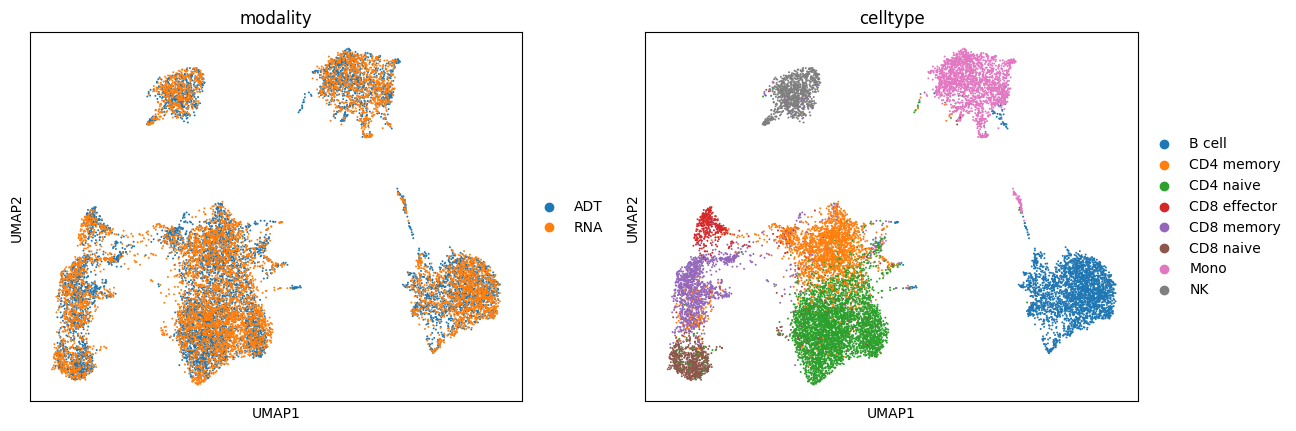

In [8]:
sc.pl.umap(adata_integrated, color=['modality','celltype'])

In [9]:
import ot
np.diag(ot.dist(adata1.obsm['link_feat'], adata2.obsm['link_feat'], metric='correlation')).mean()

0.5923409718301423